# Source code to reproduce the results of XOR problem in the main paper

## 1. Define the training function of CBP

In [1]:
import os
from collections import OrderedDict


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

In [2]:
sns.set_context('notebook')
sns.set_style('whitegrid')

In [3]:
result_dir = 'results/xor/'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

In [4]:
try:
    from cbpy import chaos_optim, net, plot, utils
except:
    import sys
    sys.path.append('../')
    from cbpy import chaos_optim, net, plot, utils

In [5]:
def train_xor_with_cbp(X,
                       Y,
                       z=12,
                       seed=18,
                       cbp_epoch=4000,
                       max_epoch=10000,
                       init_mode=1.,
                       beta=0.999,
                       cbp_lr=0.2,
                       bp_lr=0.2,
                       cbp_momentum=0.,
                       bp_momentum=0.,
                       record_weight=False,
                       record_out=False,
                       adam=False):
    loss_func = nn.BCELoss()
    zs = np.repeat(z, 4).astype(float)

    utils.set_random_seed(seed)
    model = net.MLPS([2, 2, 1], act_layer=nn.Sigmoid(), init_mode=init_mode, active_last=True)

    loss_list = []
    weight_list = []
    out_list = []

    ## CBP
    if cbp_epoch > 0:
        optimizer = chaos_optim.SGD(model.parameters(), lr=cbp_lr, momentum=cbp_momentum)
        for epoch in range(cbp_epoch):
            hids, out = model(X, return_hid=True)
            loss = loss_func(out, Y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step(zs, hids)

            if record_weight: weight_list.append(
                [torch.clone(p.detach()) for p in model.parameters()])
            if record_out: out_list.append(out.detach().numpy())
            loss_list.append(loss.item())

            # chaotic simulated annealing
            zs *= beta

    ## BP
    if adam:
        optimizer = torch.optim.Adam(model.parameters(), lr=bp_lr)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=bp_lr, momentum=bp_momentum)
    for epoch in range(cbp_epoch, max_epoch):
        _, out = model(X)
        loss = loss_func(out, Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if record_weight: weight_list.append(
            [torch.clone(p.detach()) for p in model.parameters()])
        if record_out: out_list.append(out.detach().numpy())
        loss_list.append(loss.item())
        
    return loss_list, weight_list, out_list

In [6]:
def run_xor_example(X, Y, init_mode=1., n_repeat=100, method='CBP', optim='GD', **params):
    assert method in ['BP', 'CBP'], 'must be one of BP and CBP'
    assert optim in ['GD', 'Momentum', 'Adam'], 'must be one of GD, Momentum, Adam'
    
    if method == 'BP':
        cbp_epoch = 0
    else:
        if optim == 'GD':
            cbp_epoch = 10000
        else:
            cbp_epoch = 4000
            
    if optim == 'GD':
        momentum = 0
        adam = False
    elif optim == 'Momentum':
        momentum = 0.9
        adam = False
    else:
        momentum = 0.9
        adam = True
        
    print('=' * 15 + ' traning start ' + '=' * 15)
    print('method  optim  init  seed  loss  output')
    loss_list = []
    out_list = []
    for i in range(n_repeat):
        loss, _, out = train_xor_with_cbp(X, Y, cbp_epoch=cbp_epoch, seed=i, init_mode=init_mode,
                                          record_out=True, bp_momentum=momentum, adam=adam, **params)
        loss_list.append(loss[-1])
        out_list.append(out[-1])
        print(method, optim, init_mode, i + 1, loss[-1], out[-1].flatten())
    print('=' * 15 + ' traning finish ' + '=' * 15)
        
    return loss_list, out_list

In [7]:
# inputs (X) and targets (Y) of XOR problem
X = torch.Tensor([[1., 1.],
                  [1., 0.],
                  [0., 1.],
                  [0., 0.]])
d = 0.1 # delta
Y = torch.Tensor([[d], [1 - d], [1 - d], [d]])

## 2. Validate the chaotic dynamics in weight space

In [7]:
# perform training with different chaotic intensity z (without gradient term)
# may cost several minutes
z = 12 # chaotic intensity
cbp_weight_lists = []
for i in tqdm(range(1200)):
    _, cbp_weight_list, _ = train_xor_with_cbp(
        X, Y, z=z, seed=32, cbp_epoch=500, max_epoch=500,
        record_weight=True, record_out=False, beta=1, cbp_lr=0.)
    z *= 0.999
    cbp_weight_lists.append([w[0][0, 0].item() for w in cbp_weight_list])

In [8]:
import nolds

# calculate the Lyapunov exponent with nolds
nolds_les = [nolds.lyap_e(l)[0] for l in cbp_weight_lists]
np.savetxt(f'{result_dir}w1_lyapunov_example.txt', np.array(nolds_les))

In [9]:
# the chaotic dynamics of the first weight
cbp_loss_list, cbp_weight_list, cbp_out_list = train_xor_with_cbp(
    X, Y, seed=32, cbp_epoch=1200, max_epoch=1200, record_weight=True, cbp_lr=0.)
cbp_w1_list = [w[0][0, 0].item() for w in cbp_weight_list]

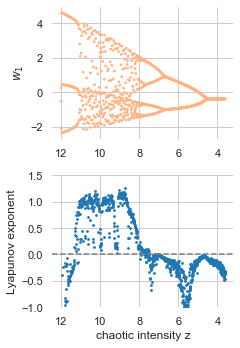

In [15]:
# plot the the Lyapunov exponent vs chaotic intensity z
zs = [12 * 0.999 ** i for i in range(1200)]
cs = sns.color_palette('pastel')
fig, ax = plt.subplots(2, 1, figsize=(3.5, 5))
ax[0].scatter(zs, cbp_w1_list, s=3, c=[cs[1]]*1200)
ax[0].set_ylabel('$w_1$')
ax[1].scatter(zs, nolds_les, s=3)
ax[1].set_ylim(-1, 1.5)
ax[1].axhline(y=0, ls='dashed', c='gray')
ax[1].set_ylabel('Lyapunov exponent')
ax[1].set_xlabel('chaotic intensity z')
for a in ax:
    sns.despine(ax=a, left=True, bottom=True)
    a.invert_xaxis()
fig.tight_layout()
fig.savefig(f'{result_dir}bp_cbp_w1_lyapunov_example.png', dpi=300)
plt.show()

## 3. Compare the learning curves of BP and CBP with one example

In [11]:
# preform BP and CBP training
seed = 32
max_epoch = 10000
cbp_loss_list, cbp_weight_list, cbp_out_list = train_xor_with_cbp(
    X, Y, seed=seed, cbp_epoch=max_epoch, max_epoch=max_epoch, record_weight=True)
bp_loss_list, bp_weight_list, bp_out_list = train_xor_with_cbp(
    X, Y, seed=seed, cbp_epoch=0, max_epoch=max_epoch, record_weight=True)

# the first weight
bp_w1_list = [w[0][0, 0].item() for w in bp_weight_list]
cbp_w1_list = [w[0][0, 0].item() for w in cbp_weight_list]

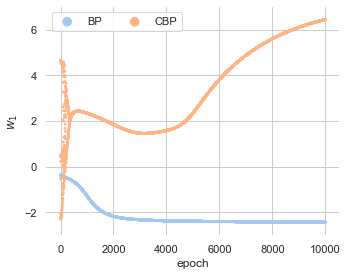

In [12]:
# plot the trajectories of the first weights of BP and CBP
cs = sns.color_palette('pastel')

fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(range(max_epoch), bp_w1_list, s=3, c=[cs[0]]*max_epoch, label='BP')
ax.scatter(range(max_epoch), cbp_w1_list, s=3, c=[cs[1]]*max_epoch, label='CBP')
ax.legend(loc='upper left', ncol=2, markerscale=5)
ax.set_ylabel('$w_1$')
ax.set_xlabel('epoch')
sns.despine(ax=ax, left=True, bottom=True)
ax.set_ylim(-3, 7)
fig.tight_layout()
fig.savefig(f'{result_dir}bp_cbp_w1_example.png', dpi=300)
plt.show()

In [13]:
def plot_xor_weight(ws, suptitle=None, save_prefix=None, suffix='weight'):
    ws1 = np.array([w[0].flatten().numpy() for w in ws])
    bs1 = np.array([w[1].flatten().numpy() for w in ws])
    ws2 = np.array([w[2].flatten().numpy() for w in ws])
    bs2 = np.array([w[3].flatten().numpy() for w in ws])
    w = np.hstack([ws1, bs1, ws2, bs2])
    plot.plot_w_traj(w, first=9, save_prefix=save_prefix, suffix=suffix, suptitle=suptitle)

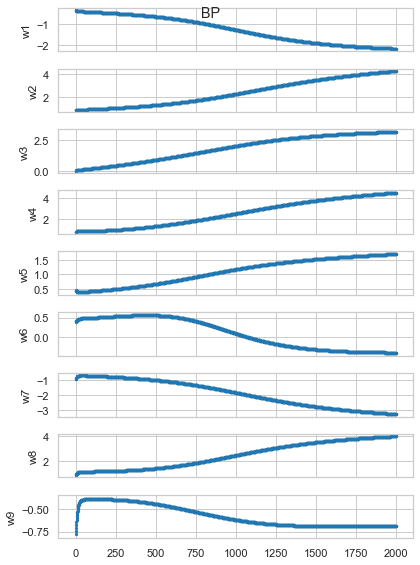

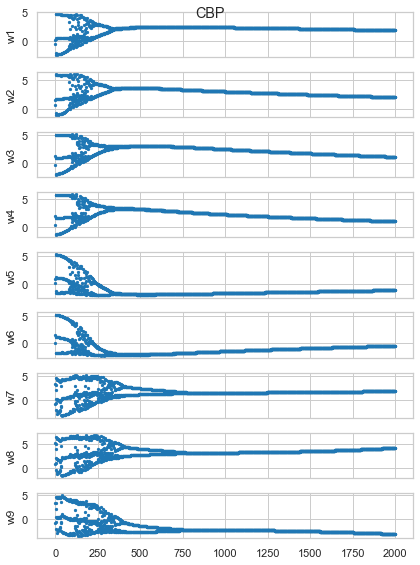

In [14]:
plot_xor_weight(bp_weight_list[:2000], suptitle='BP')
plot_xor_weight(cbp_weight_list[:2000], suptitle='CBP')

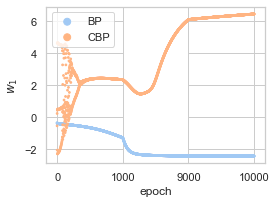

In [15]:
# zoom in the trajectories
tmp_bp_w1_list = bp_w1_list[:1000] + bp_w1_list[1000:9000:8] + bp_w1_list[9000:]
tmp_cbp_w1_list = cbp_w1_list[:1000] + cbp_w1_list[1000:9000:8] + cbp_w1_list[9000:]
n_point = len(tmp_bp_w1_list)
fig, ax = plt.subplots(figsize=(4, 3))
ax.axvspan(xmin=1020, xmax=1980, fc='white', zorder=1)
ax.scatter(range(n_point), tmp_bp_w1_list, s=3, c=[cs[0]]*n_point, label='BP', zorder=2)
ax.scatter(range(n_point), tmp_cbp_w1_list, s=3, c=[cs[1]]*n_point, label='CBP', zorder=3)
ax.legend(loc='upper left', ncol=1, markerscale=4)
ax.set_ylabel('$w_1$')
ax.set_xlabel('epoch')
ax.set_xticks([0, 1000, 2000, 3000])
ax.set_xticklabels([0, 1000, 9000, 10000])
fig.tight_layout()
fig.savefig(f'{result_dir}bp_cbp_w1_break_example.png', dpi=300)
plt.show()

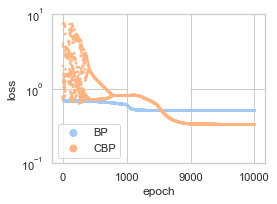

In [16]:
# plot the trajectories of the loss of BP and CBP
tmp_bp_loss_list = bp_loss_list[:1000] + bp_loss_list[1000:9000:8] + bp_loss_list[9000:]
tmp_cbp_loss_list = cbp_loss_list[:1000] + cbp_loss_list[1000:9000:8] + cbp_loss_list[9000:]

n_point = len(tmp_bp_loss_list)
fig, ax = plt.subplots(figsize=(4, 3))
ax.axvspan(xmin=1020, xmax=1980, fc='white', zorder=1)
ax.scatter(range(n_point), tmp_bp_loss_list, s=3, c=[cs[0]]*n_point, label='BP', zorder=2)
ax.scatter(range(n_point), tmp_cbp_loss_list, s=3, c=[cs[1]]*n_point, label='CBP', zorder=3)
ax.legend(loc='lower left', ncol=1, markerscale=4)
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.set_xticks([0, 1000, 2000, 3000])
ax.set_xticklabels([0, 1000, 9000, 10000])
ax.set_ylim(0.1, 10)
ax.set_yscale('log')
fig.tight_layout()
fig.savefig(f'{result_dir}bp_cbp_loss_break_example.png', dpi=300)
plt.show()

## 4. Stochastic Back-Propagation (SBP)

### 4.1 Implementation of  SBP algorithm 

In [17]:
def zero_grad(params):
    for p in params:
        p.grad = None

def model_params_to_vec(params):
    vec = np.hstack([p.flatten().detach().numpy() for p in params])
    return vec

def params_grad_to_vec(params):
    vec = np.hstack([p.grad.flatten().numpy() for p in params])
    return vec

def vec_to_model_params(vec):
    w1 = torch.from_numpy(vec[:4]).reshape(2, 2)
    b1 = torch.from_numpy(vec[4:6])
    w2 = torch.from_numpy(vec[6:8]).reshape(1, 2)
    b2 = torch.from_numpy(vec[8:])
    state_dict = OrderedDict()
    state_dict['model.0.weight'] = w1
    state_dict['model.0.bias'] = b1
    state_dict['model.1.weight'] = w2
    state_dict['model.1.bias'] = b2
    return state_dict

def train_xor_with_sbp(X,
                       Y,
                       L=500,
                       max_epoch=100,
                       delta=0.2,
                       T0=1,
                       beta=0.95,
                       init_mode=.5,
                       seed=0,
                       bound=30,
                       record_full=False):
    utils.set_random_seed(seed)
    model = net.MLPS([2, 2, 1], act_layer=nn.Sigmoid(), active_last=True,
                     init_mode=init_mode)
    loss_func = nn.BCELoss()
    T = T0

    ws_list = []
    loss_list = []
    out_list = []
    for _ in range(L):
        for epoch in range(max_epoch):
            accept = False

            zero_grad(model.parameters())
            out = model(X)[1]
            loss = loss_func(out, Y)
            loss.backward()
            ws = model_params_to_vec(model.parameters())
            ws_grad = params_grad_to_vec(model.parameters())

            idx = np.random.choice(range(len(ws_grad)), 1)
            del_w = np.random.choice([-delta, delta])
            del_E = ws_grad[idx] * del_w

            if del_E <= 0:
                accept = True
            else:
                if np.exp(-del_E / T) > np.random.random():
                    accept = True

            if accept:
                if -bound < ws[idx] + del_w < bound:
                    ws[idx] += del_w
                    model.load_state_dict(vec_to_model_params(ws))

            if record_full:
                ws_list.append(ws)
                loss_list.append(loss.item())
                out_list.append(out.detach().numpy())

        if not record_full:
            ws_list.append(ws)
            loss_list.append(loss.item())
            out_list.append(out.detach().numpy())

        T *= beta
    return loss_list, ws_list, out_list

In [18]:
def run_xor_sbp_example(X, Y, init_mode=1., n_repeat=100, **params):
    sbp_loss_list = []
    sbp_out_list = []
    for seed in range(n_repeat):
        loss_list, _, out_list = train_xor_with_sbp(
            X, Y, init_mode=init_mode, seed=seed, **params)
        print('SBP', init_mode, seed+1, loss_list[-1], out_list[-1].flatten())
        sbp_loss_list.append(loss_list[-1])
        sbp_out_list.append(out_list[-1])
    return sbp_loss_list, sbp_out_list

### 4.2 Two opposing examples of SBP training

In [19]:
loss_list, weight_list, out_list = train_xor_with_sbp(
    X, Y, init_mode=1., seed=89) # local minima
loss_list2, weight_list2, out_list2 = train_xor_with_sbp(
    X, Y, init_mode=1., seed=90) # global minima

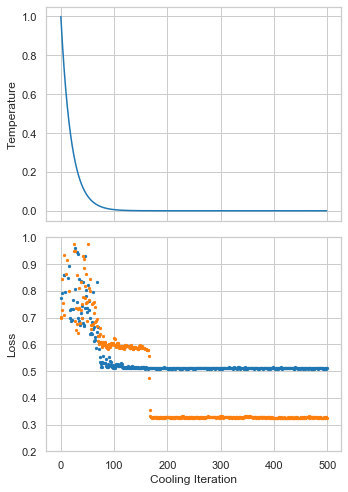

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(5, 7), sharex=True)
ax[0].plot([0.95 ** i for i in range(500)])
ax[1].scatter(range(500), loss_list, s=5)
ax[1].scatter(range(500), loss_list2, s=5)
ax[1].set_ylim(0.2, 1)
ax[0].set_ylabel('Temperature')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Cooling Iteration')
fig.tight_layout()
fig.savefig(f'{result_dir}sbp_loss_example.png', dpi=300)
plt.show()

### 4.3 An example shows the differences of the dynamics of the weights between BP, CBP and SBP

In [21]:
seed = 32
sbp_loss_list, sbp_weight_list, sbp_out_list = train_xor_with_sbp(
    X, Y, init_mode=1., seed=seed, L=10, record_full=True)
cbp_loss_list, cbp_weight_list, cbp_out_list = train_xor_with_cbp(
    X, Y, seed=seed, cbp_epoch=1000, max_epoch=1000, record_weight=True)
bp_loss_list, bp_weight_list, bp_out_list = train_xor_with_cbp(
    X, Y, seed=seed, cbp_epoch=0, max_epoch=1000, record_weight=True)

In [22]:
sbp_w1 = [w[0] for w in sbp_weight_list]
sbp_w7 = [w[6] for w in sbp_weight_list]
cbp_w1 = [w[0][0, 0] for w in cbp_weight_list]
cbp_w7 = [w[2][0, 0] for w in cbp_weight_list]
bp_w1 = [w[0][0, 0] for w in bp_weight_list]
bp_w7 = [w[2][0, 0] for w in bp_weight_list]

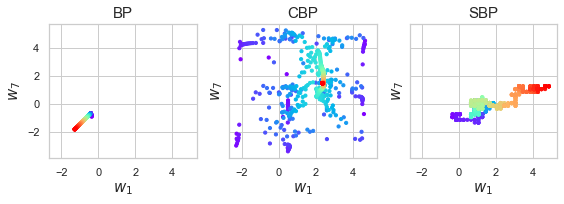

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True)
im1 = ax[0].scatter(bp_w1, bp_w7, s=10, c=range(1000), cmap='rainbow')
im2 = ax[1].scatter(cbp_w1, cbp_w7, s=10, c=range(1000), cmap='rainbow')
im3 = ax[2].scatter(sbp_w1, sbp_w7, s=10, c=range(1000), cmap='rainbow')
titles = ['BP', 'CBP', 'SBP']
for i in range(3):
    ax[i].set_xlabel(r'$w_1$', fontsize=15)
    ax[i].set_ylabel(r'$w_7$', fontsize=15)
    ax[i].set_title(titles[i], fontsize=15)
fig.tight_layout()
fig.savefig(f'{result_dir}bp_cbp_sbp_w1_w7_example.png', dpi=300)
plt.show()

## 5. Systematic comparison of the ability of finding global mimina between BP, CBP and SBP

### 5.1 main program to reproduce the results

In [ ]:
# perform 100 different training runs with 4 different initial weight interval
# Note: This cell may cost several hours.
# To save time, you can also directly use the results provided by us (skip to 5.2).
bp_loss_lists = []
cbp_loss_lists = []
sbp_loss_lists = []
for init_mode in [0.2, 0.5, 1., 3.]:
    bp_loss_list, bp_out_list = run_xor_example(X, Y, init_mode=init_mode, method='BP')
    cbp_loss_list, cbp_out_list = run_xor_example(X, Y, init_mode=init_mode, method='CBP')
    sbp_loss_list, sbp_out_list = run_xor_sbp_example(X, Y, init_mode=init_mode)
    bp_loss_lists.append(bp_loss_list)
    cbp_loss_lists.append(cbp_loss_list)
    sbp_loss_lists.append(sbp_loss_list)

In [25]:
tmp_loss_lists = [bp_loss_lists, cbp_loss_lists, sbp_loss_lists]
results = []
for i, method in enumerate(['BP', 'CBP', 'SBP']):
    for j, init in enumerate([0.2, 0.5, 1., 3.]):
        for seed in range(100):
            results.append([init, method, seed, tmp_loss_lists[i][j][seed]])

In [26]:
def to_minimas(loss_list):
    minimas = []
    for l in loss_list:
        if l < 0.35:
            minimas.append('g')
        elif l < 0.55:
            minimas.append('b')
        elif l < 0.65:
            minimas.append('c+d')
        else:
            minimas.append('a')
    return minimas

In [27]:
example_minimas = [
    torch.Tensor([[d], [1 - d], [1 - d], [d]]), # g, global
    torch.Tensor([[.5], [.5], [.5], [.5]]), # a, local
    torch.Tensor([[.5], [.5], [1 - d], [d]]), # b, local
    torch.Tensor([[.633], [.633], [.633], [d]]), # c, local
    torch.Tensor([[.366], [1 - d], [.366], [.366]]), # d, local
]

loss_func = nn.BCELoss()
minimas_loss = [round(loss_func(minima, Y).item(), 3) for minima in example_minimas]

In [28]:
df = pd.DataFrame(results, columns=['init', 'method', 'seed', 'loss'])
df['type'] = to_minimas(df.loss)
df.to_csv(f'{result_dir}bp_cbp_sbp_best_loss.csv', index=False)

### 5.2 plot the distributions of the minimas under different initial conditions

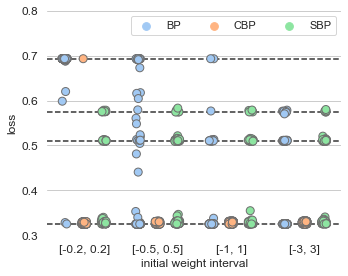

In [29]:
df = pd.read_csv(f'{result_dir}bp_cbp_sbp_best_loss.csv')

fig, ax = plt.subplots(figsize=(5, 4))
ax = sns.stripplot(x='init', y='loss', hue='method', data=df,
                   size=8, color='.3', ax=ax, dodge=True, palette="pastel",
                   linewidth=1., hue_order=['BP', 'CBP', 'SBP'])
ax.set_ylim(0.3, 0.8)
# ax.axhspan(ymin=0.3, ymax=0.35, facecolor='0.8')
# ax.axhspan(ymin=0.35, ymax=0.55, facecolor='0.95')
# ax.axhspan(ymin=0.55, ymax=0.65, facecolor='0.8')
# ax.axhspan(ymin=0.60, ymax=0.80, facecolor='0.95')
ax.set_xticklabels(['[-0.2, 0.2]', '[-0.5, 0.5]', '[-1, 1]', '[-3, 3]'], fontsize=12, rotation=0)
ax.set_yticklabels(['%2.1f' % i for i in np.arange(0.3, 0.81, 0.1)], fontsize=12)
ax.set_xlabel('initial weight interval', fontsize=12)
ax.set_ylabel('loss', fontsize=12)
ax.legend(ncol=3, title='')
for l in minimas_loss[:4]:
    ax.axhline(y=l, c='k', ls='--', alpha=.8)
sns.despine(ax=ax, left=True, bottom=True)
fig.tight_layout()
# fig.savefig(f'{result_dir}compare_loss_bp_cbp_sbp.png', dpi=300)
plt.show()

### 5.3 plot the percentage of global minimal for three method

In [30]:
counts = []
for method in ['BP', 'CBP', 'SBP']:
    for i, init in enumerate([0.2, 0.5, 1., 3.]):
        tmp = df[(df.init == init) & (df.method == method)].type.value_counts()
        for minima in  ['a', 'b', 'c+d', 'g']:
            try:
                n = tmp[minima]
                counts.append([init, method, minima, n])
            except:
                counts.append([init, method, minima, 0])
df = pd.DataFrame(counts, columns=['init', 'method', 'minima', 'count'])
df.to_csv('results/xor/bp_cbp_sbp_minima_counts.csv', index=False)

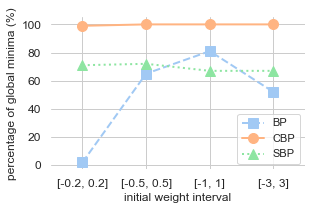

In [31]:
cs = sns.color_palette('pastel')
lss = ['--', '-', ':']
ms = ['s', 'o', '^']
fig, ax = plt.subplots(figsize=(4.5, 3))
for i, m in enumerate(['BP', 'CBP', 'SBP']):
    ax.plot(range(4), df[(df.method==m) & (df.minima=='g')].loc[:,'count'], color=cs[i], lw=2.,
            linestyle=lss[i], marker=ms[i], label=m, markersize=10)
ax.legend(fontsize=12, title='method')
ax.set_xticks(range(4))
ax.set_xticklabels(['[-0.2, 0.2]', '[-0.5, 0.5]', '[-1, 1]', '[-3, 3]'], fontsize=12, rotation=0)
ax.set_yticks(range(0, 101, 20))
ax.set_yticklabels(range(0, 101, 20), fontsize=12)
ax.set_xlim(-.5, 3.5)
ax.set_xlabel('initial weight interval', fontsize=12)
ax.set_ylabel('percentage of global minima (%)', fontsize=12)
ax.legend(title='')
sns.despine(ax=ax, bottom=True, left=True)
fig.tight_layout()
# fig.savefig(f'{result_dir}global_minima_bp_cbp_sbp.png', dpi=300)
plt.show()

## 6. Combination with Momentum or Adam 

### 6.1 an example shows that Momentum (or Adam) may improve the performance of BP and CBP

In [32]:
seed = 32
loss_bp, weight_bp, out_bp = train_xor_with_cbp(X, Y, cbp_epoch=0, init_mode=1., seed=seed,
                                                record_weight=True, record_out=True)
loss_bp_M, weight_bp_M, out_bp_M = train_xor_with_cbp(X, Y, cbp_epoch=0, init_mode=1., bp_momentum=.9, seed=seed,
                                                      record_weight=True, record_out=True)
loss_bp_A, weight_bp_A, out_bp_A = train_xor_with_cbp(X, Y, cbp_epoch=0, init_mode=1., adam=True, seed=seed,
                                                      record_weight=True, record_out=True)
loss_cbp, weight_cbp, out_cbp = train_xor_with_cbp(X, Y, cbp_epoch=10000, init_mode=1., seed=seed,
                                                record_weight=True, record_out=True)
loss_cbp_M, weight_cbp_M, out_cbp_M = train_xor_with_cbp(X, Y, cbp_epoch=4000, init_mode=1., bp_momentum=.9,
                                                record_weight=True, record_out=True, seed=seed)
loss_cbp_A, weight_cbp_A, out_cbp_A = train_xor_with_cbp(X, Y, cbp_epoch=4000, init_mode=1., adam=True,
                                                record_weight=True, record_out=True, seed=seed)

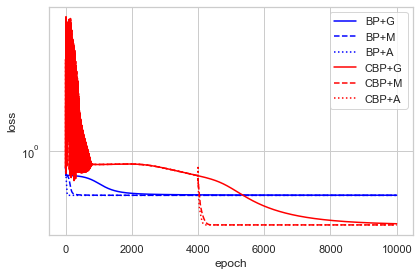

In [33]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(loss_bp, 'b-', label='BP+G')
ax.plot(loss_bp_M, 'b--', label='BP+M')
ax.plot(loss_bp_A, 'b:', label='BP+A')
ax.plot(loss_cbp, 'r-', label='CBP+G')
ax.plot(loss_cbp_M, 'r--', label='CBP+M')
ax.plot(loss_cbp_A, 'r:', label='CBP+A')
ax.legend()
ax.set_yscale('log')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
fig.tight_layout()
fig.savefig(f'{result_dir}bp_cbp_G_M_A_example_seed32.png', dpi=300)
plt.show()

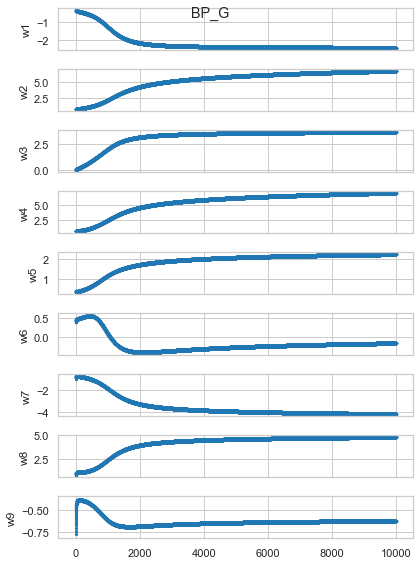

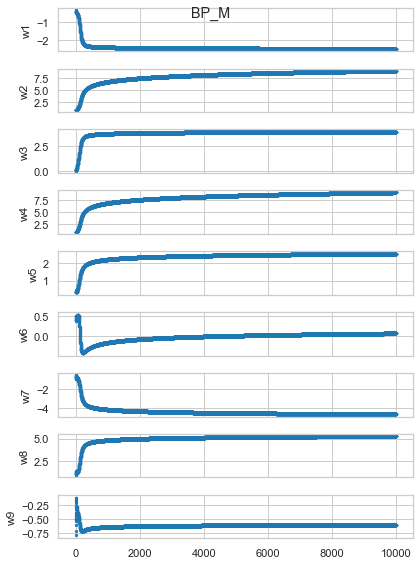

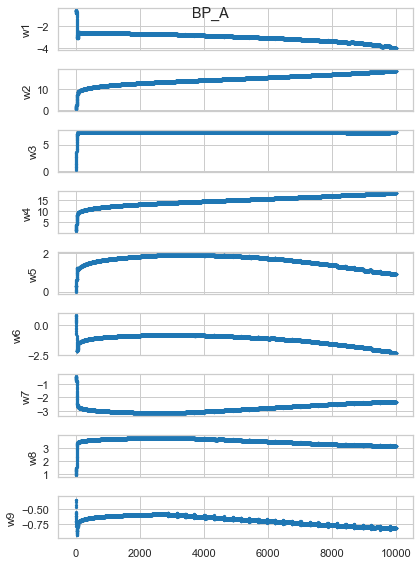

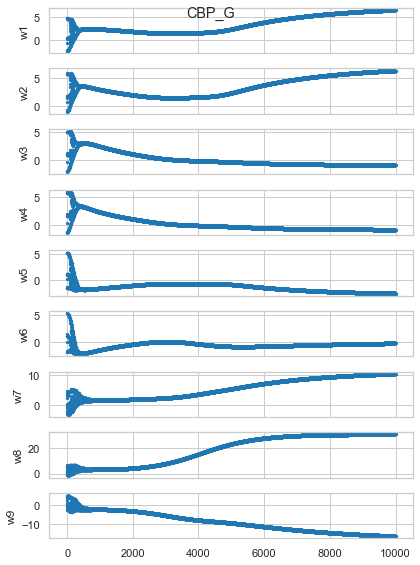

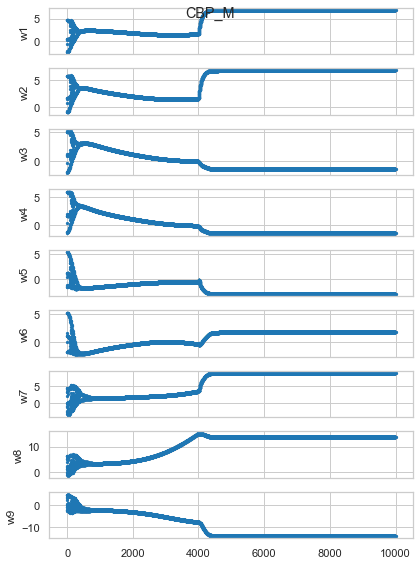

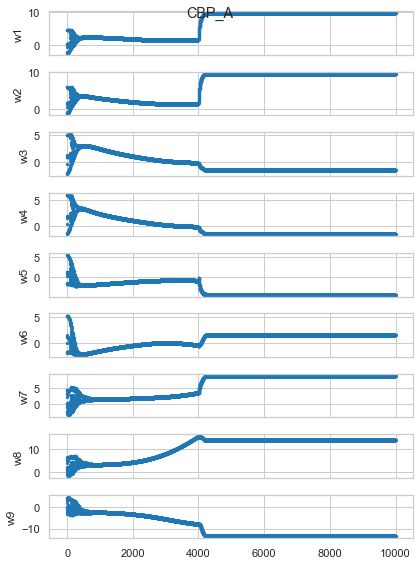

In [34]:
labels = ['BP_G', 'BP_M', 'BP_A', 'CBP_G', 'CBP_M', 'CBP_A']
for i, ws in enumerate([weight_bp, weight_bp_M, weight_bp_A, weight_cbp, weight_cbp_M, weight_cbp_A]):
    plot_xor_weight(ws, suptitle=labels[i])

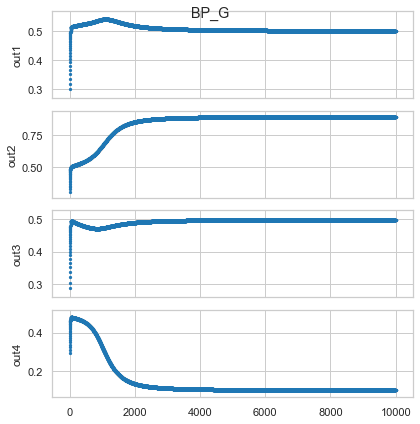

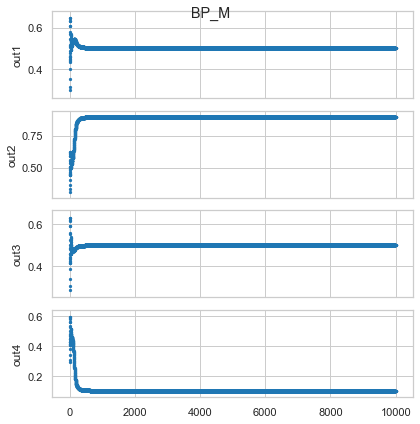

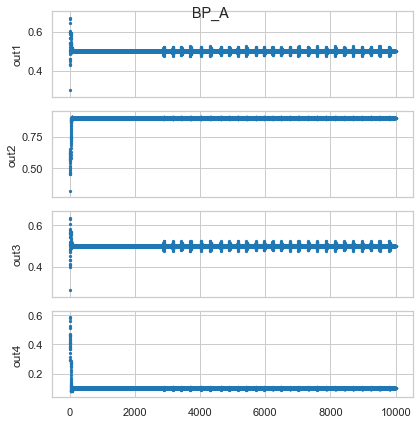

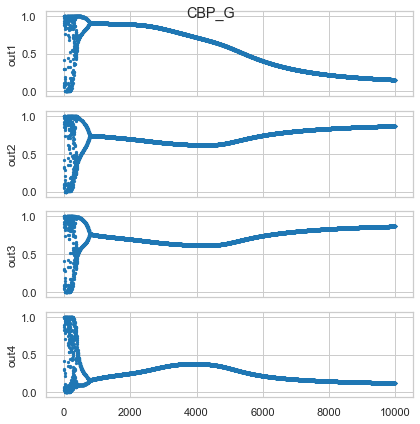

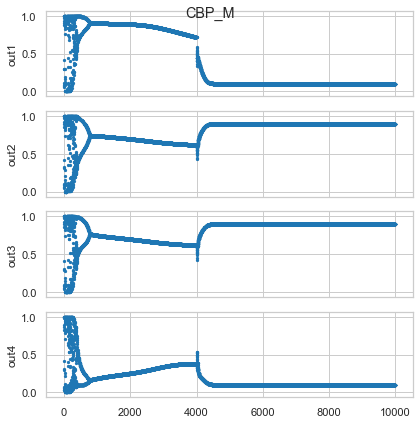

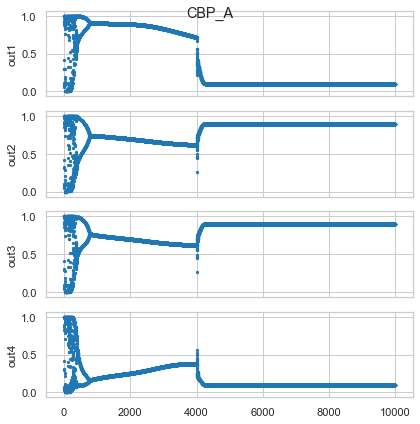

In [35]:
for i, os in enumerate([out_bp, out_bp_M, out_bp_A, out_cbp, out_cbp_M, out_cbp_A]):
    outs = np.hstack(os).T
    plot.plot_out_traj(outs, suptitle=labels[i], figsize=(6, 6))

### 6.2 run 100 BP and CBP tranings with Momentum (or Adam)

In [ ]:
bp_M_loss_lists = []
bp_A_loss_lists = []
cbp_M_loss_lists = []
cbp_A_loss_lists = []
for init_mode in [0.2, 0.5, 1., 3.]:
    bp_M_loss_list, bp_M_out_list = run_xor_example(X, Y, init_mode=init_mode, method='BP', optim='Momentum')
    bp_A_loss_list, bp_A_out_list = run_xor_example(X, Y, init_mode=init_mode, method='BP', optim='Adam')
    cbp_M_loss_list, cbp_M_out_list = run_xor_example(X, Y, init_mode=init_mode, method='CBP', optim='Momentum')
    cbp_A_loss_list, cbp_A_out_list = run_xor_example(X, Y, init_mode=init_mode, method='CBP', optim='Adam')
    bp_M_loss_lists.append(bp_M_loss_list)
    bp_A_loss_lists.append(bp_A_loss_list)
    cbp_M_loss_lists.append(cbp_M_loss_list)
    cbp_A_loss_lists.append(cbp_A_loss_list)

In [37]:
tmp_loss_lists = [[bp_M_loss_lists, bp_A_loss_lists], [cbp_M_loss_lists, cbp_M_loss_lists]]
results = []
for i, method in enumerate(['BP', 'CBP']):
    for j, optim in enumerate(['Momentum', 'Adam']):
        for k, init in enumerate([0.2, 0.5, 1., 3.]):
            for seed in range(100):
                results.append([init, method, optim, seed, tmp_loss_lists[i][j][k][seed]])

In [38]:
df_M_A = pd.DataFrame(results, columns=['init', 'method', 'optim', 'seed', 'loss'])
df_M_A['type'] = to_minimas(df_M_A.loss)

In [39]:
df_mix = pd.read_csv(f'{result_dir}bp_cbp_sbp_best_loss.csv')
df_G = df_mix[df_mix.method != 'SBP']
df_G.loc[:, 'optim'] = 'GD'

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [40]:
df = pd.concat((df_G, df_M_A))
df.to_csv(f'{result_dir}G_M_A_best_loss.csv', index=False)

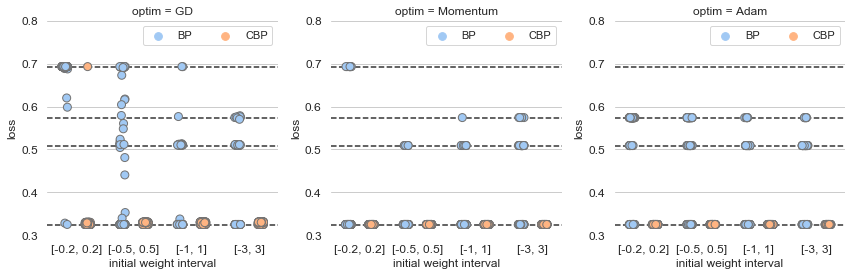

In [41]:
df = pd.read_csv(f'{result_dir}G_M_A_best_loss.csv')
optims = ['GD', 'Momentum', 'Adam']
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i, ax in enumerate(axs):
    ax = sns.stripplot(x='init', y='loss', hue='method', data=df[df.optim==optims[i]],
                       size=8, color='.3', ax=ax, dodge=True, palette="pastel",
                       linewidth=1., hue_order=['BP', 'CBP'])
    ax.set_ylim(0.3, 0.8)
    ax.set_xticklabels(['[-0.2, 0.2]', '[-0.5, 0.5]', '[-1, 1]', '[-3, 3]'], fontsize=12, rotation=0)
    ax.set_yticklabels(['%2.1f' % i for i in np.arange(0.3, 0.81, 0.1)], fontsize=12)
    ax.set_xlabel('initial weight interval', fontsize=12)
    ax.set_ylabel('loss', fontsize=12)
    ax.legend(ncol=2, title='')
    for l in minimas_loss[:4]:
        ax.axhline(y=l, c='k', ls='--', alpha=.8)
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set_title(f'optim = {optims[i]}')
fig.tight_layout()
# fig.savefig(f'{result_dir}G_M_A_loss.png', dpi=300)
plt.show()

In [42]:
counts = []
for method in ['BP', 'CBP']:
    for optim in ['GD', 'Momentum', 'Adam']:
        for i, init in enumerate([0.2, 0.5, 1., 3.]):
            tmp = df[(df.init == init) & (df.method == method) & (df.optim == optim)].type.value_counts()
            for minima in  ['a', 'b', 'c+d', 'g']:
                try:
                    n = tmp[minima]
                    counts.append([init, method, optim, minima, n])
                except:
                    counts.append([init, method, optim, minima, 0])
df = pd.DataFrame(counts, columns=['init', 'method', 'optim', 'minima', 'count'])

df.to_csv(f'{result_dir}G_M_A_minima_counts.csv', index=False)

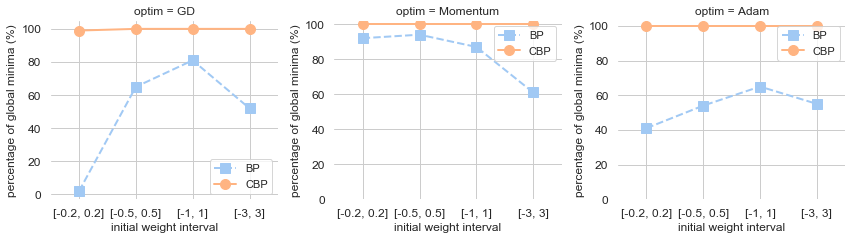

In [43]:
cs = sns.color_palette('pastel')
lss = ['--', '-']
ms = ['s', 'o']
optims = ['GD', 'Momentum', 'Adam']
fig, axs = plt.subplots(1, 3, figsize=(12, 3.5))
for i, ax in enumerate(axs): 
    for j, m in enumerate(['BP', 'CBP']):
        ax.plot(range(4), df[(df.method==m) & (df.minima=='g') & (df.optim==optims[i])].loc[:,'count'], color=cs[j], lw=2.,
                linestyle=lss[j], marker=ms[j], label=m, markersize=10)
    ax.legend(fontsize=12, title='method')
    ax.set_xticks(range(4))
    ax.set_xticklabels(['[-0.2, 0.2]', '[-0.5, 0.5]', '[-1, 1]', '[-3, 3]'], fontsize=12, rotation=0)
    ax.set_yticks(range(0, 101, 20))
    ax.set_yticklabels(range(0, 101, 20), fontsize=12)
    ax.set_xlim(-.5, 3.5)
    ax.set_xlabel('initial weight interval', fontsize=12)
    ax.set_ylabel('percentage of global minima (%)', fontsize=12)
    ax.legend(title='')
    sns.despine(ax=ax, bottom=True, left=True)
    ax.set_title(f'optim = {optims[i]}')
fig.tight_layout()
fig.savefig(f'{result_dir}G_M_A_count.png', dpi=300)
plt.show()

## 7. Compared with meta-heuristic algorithm (GA and PSO)

In [44]:
from sko.GA import GA
from sko.PSO import PSO

In [45]:
def nn_forward(v):
    model.load_state_dict(vec_to_model_params(v))
    loss = loss_func(model(X)[1], Y).item()
    return loss

In [46]:
###
model = net.MLPS([2, 2, 1], act_layer=nn.Sigmoid(), active_last=True)

ga_best_ws = []
ga_loss_list = []
for seed in range(100):
    ga = GA(func=nn_forward, n_dim=9, size_pop=50, max_iter=1000,
            lb=[-30] * 9, ub=[30] * 9, precision=1e-1, prob_mut=0.01)
    utils.set_random_seed(seed)
    ga.Chrom = np.random.randint(0, 2, size=ga.Chrom.shape)
    best_w = ga.run()

    ga_best_ws.append(best_w)
    Y_history = pd.DataFrame(ga.all_history_Y)
    ga_loss_list.append(Y_history.min(axis=1).cummin())
    model.load_state_dict(vec_to_model_params(best_w[0]))
    out = model(X)[1].detach().numpy().flatten()
    print(seed, best_w[1], out)

0 [0.50911522] [0.5       0.8997605 0.5       0.0997877]
1 [0.32508314] [0.09991918 0.89976287 0.8999675  0.09980336]
2 [0.32508343] [0.09992233 0.90055394 0.89992946 0.09987387]
3 [0.32508922] [0.09996972 0.8995745  0.8997222  0.10206773]
4 [0.32517308] [0.10249611 0.89478743 0.89478636 0.10246971]
5 [0.50926584] [0.09473328 0.49253234 0.8989288  0.492669  ]
6 [0.32509199] [0.09931892 0.8999852  0.90002507 0.10246897]
7 [0.32509133] [0.10005286 0.897531   0.90001994 0.09991962]
8 [0.50916886] [0.4926691  0.8999845  0.4926691  0.10022403]
9 [0.325086] [0.09990583 0.90003973 0.9000772  0.0985416 ]
10 [0.32508314] [0.09995016 0.90003073 0.8999738  0.10030957]
11 [0.41732994] [0.0998202  0.6358009  0.6340722  0.09980621]
12 [0.32513645] [0.10246903 0.89480203 0.9005034  0.10246903]
13 [0.32508358] [0.10064766 0.90002835 0.89997977 0.09995194]
14 [0.5091688] [0.49266922 0.900041   0.49266922 0.10004011]
15 [0.43726474] [0.13281742 0.70704037 0.8945931  0.47801262]
16 [0.32509995] [0.102469

In [47]:
ga_best_w = np.array([i[0] for i in ga_best_ws])
np.savetxt(f'{result_dir}ga_best_w.txt', ga_best_w)
ga_best_v = np.array([i[1] for i in ga_best_ws])
np.savetxt(f'{result_dir}ga_best_v.txt', ga_best_v)

np.unique(to_minimas(ga_best_v), return_counts=True)

(array(['b', 'g'], dtype='<U1'), array([30, 70], dtype=int64))

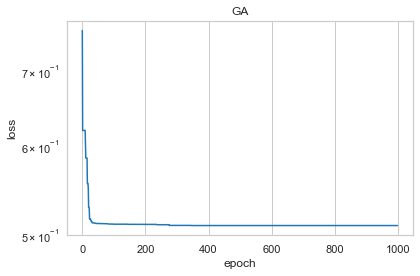

In [48]:
fig, ax = plt.subplots()
ax.plot(Y_history.min(axis=1).cummin())
ax.set_yscale('log')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.set_title('GA')
fig.tight_layout()
fig.savefig(f'{result_dir}ga_loss_example.png',dpi=300)
plt.show()

In [49]:
###
model = net.MLPS([2, 2, 1], act_layer=nn.Sigmoid(), active_last=True)

pso_best_ws = []
pso_loss_list = []
for seed in range(100):
    pso = PSO(func=nn_forward, n_dim=9, pop=100, max_iter=1000,
              lb=[-30] * 9, ub=[30] * 9, w=0.8, c1=.5, c2=.5)
    utils.set_random_seed(seed)
    pso.X = np.random.uniform(-30, 30, size=pso.X.shape)
    best_w = pso.run()

    pso_best_ws.append(best_w)
    pso_loss_list.append(pso.gbest_y_hist)
    model.load_state_dict(vec_to_model_params(best_w[0]))
    out = model(X)[1].detach().numpy().flatten()
    print(seed, best_w[1], out)

0 [0.32508296] [0.10001656 0.90004015 0.9000605  0.10001656]
1 [0.574139] [0.36662164 0.8999989  0.36662164 0.36662164]
2 [0.32508379] [0.09946252 0.9000869  0.9000097  0.10055109]
3 [0.32508299] [0.09998325 0.89989924 0.9000875  0.10000678]
4 [0.574139] [0.63337487 0.63337487 0.63337487 0.09993573]
5 [0.57413942] [0.36677372 0.36677232 0.8999337  0.36677232]
6 [0.5091151] [0.5        0.89998525 0.5        0.10005434]
7 [0.574139] [0.36669734 0.90009123 0.36669734 0.36669734]
8 [0.50911832] [0.10001896 0.89989924 0.4999919  0.5       ]
9 [0.50911528] [0.5        0.49999952 0.90001416 0.09995408]
10 [0.32508296] [0.10001656 0.90001434 0.90001297 0.10000678]
11 [0.32508302] [0.10016704 0.8999394  0.8999394  0.09995171]
12 [0.32508296] [0.10000678 0.89994967 0.89996403 0.10000678]
13 [0.574139] [0.36673415 0.36673415 0.90002537 0.36673415]
14 [0.574139] [0.3667213  0.89989126 0.3667213  0.3667213 ]
15 [0.574139] [0.36663094 0.36663094 0.899934   0.36663094]
16 [0.32508299] [0.10010665 0.8

In [50]:
pso_best_w = np.array([i[0] for i in pso_best_ws])
np.savetxt(f'{result_dir}pso_best_w.txt', pso_best_w)
pso_best_v = np.array([i[1] for i in pso_best_ws])
np.savetxt(f'{result_dir}pso_best_v.txt', pso_best_v)

np.unique(to_minimas(pso_best_v), return_counts=True)

(array(['b', 'c+d', 'g'], dtype='<U3'), array([32, 36, 32], dtype=int64))

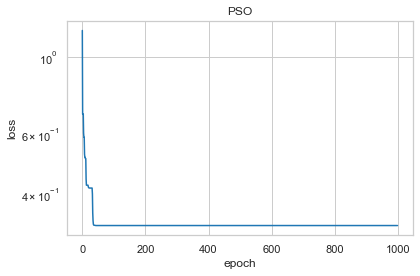

In [51]:
fig, ax = plt.subplots()
ax.plot(pso.gbest_y_hist)
ax.set_yscale('log')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.set_title('PSO')
fig.tight_layout()
fig.savefig(f'{result_dir}pso_loss_example.png',dpi=300)
plt.show()

In [52]:
ga_best_v = np.loadtxt(f'{result_dir}ga_best_v.txt')
np.unique(to_minimas(ga_best_v), return_counts=True)
pso_best_v = np.loadtxt(f'{result_dir}pso_best_v.txt')
np.unique(to_minimas(pso_best_v), return_counts=True)
df = pd.DataFrame([['GA', v] for v in ga_best_v] + [['PSO', v] for v in pso_best_v],
                  columns=['method', 'loss'])

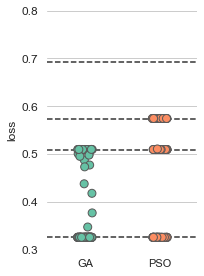

In [53]:
fig, ax = plt.subplots(figsize=(3, 4))
sns.stripplot(x='method', y='loss', size=8, color='.3', linewidth=1., data=df,
              palette='Set2')
ax.set_ylim(0.3, 0.8)
ax.set_yticklabels(['%2.1f' % i for i in np.arange(0.3, 0.81, 0.1)], fontsize=12)
ax.set_xlabel('')
ax.set_ylabel('loss', fontsize=12)
for l in minimas_loss[:4]:
    ax.axhline(y=l, c='k', ls='--', alpha=.8)
sns.despine(ax=ax, left=True, bottom=True)
fig.tight_layout()
fig.savefig(f'{result_dir}ga_pso_loss.png',dpi=300)
plt.show()